# Estimate Strawberry's Taste and Acidity based on Images

## 0. Import modules

I executed this python notebook on Google Colabortary. Before executing, it's necessary to mount google drive. If you don't run this notebook on Google Coabortary, you can skip the first cell.

In [26]:
import numpy as np
import pandas as pd
import os
import re
import csv
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import KFold

Select a device (CPU or GPU)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.backends.cudnn.benchmark = True


cuda:0


## 1. Load Datasets

In [28]:
PATH = 'Images/'
images = []
brix = []
acidity = []
with open('Annotations.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i, rows in enumerate(reader):
        if i != 0:
            images.append(PATH+rows[0].strip())
            brix.append(float(rows[2]))
            acidity.append(float(rows[3]))

Data0 = {'image': images, 'brix': brix, 'acid': acidity}
Data0=pd.DataFrame(Data0)


In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

**Create a custom dataset class.**\
We noticed that some filenames in the `Annotations.csv` file does not match that of images in the dataset folder, which may result in errors. Therefore, we need to check whether the filenames in the `Annotations.csv` is correct. If not, we should modify the filename. In this program, we used a simple and brutal solution: substitute the word ripe/unripe/partripe in the filename with another word and check whether the filename is correct by function `os.path.exists()`.

In [30]:
class MyDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        imgPath = self.img_data.loc[index, 'image']
        if not os.path.exists(imgPath):
            ripe = imgPath.split('_')[2].split('.')[0]
            for subst in ('ripe', 'unripe', 'partripe'):
                if os.path.exists(re.sub(ripe, subst, imgPath)):
                    imgPath = re.sub(ripe, subst, imgPath)

        image = cv2.imread(imgPath)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (64, 64))
        brix = self.img_data.loc[index, 'brix']
        acid = self.img_data.loc[index, 'acid']
        if self.transform is not None:
            image = self.transform(image)
        return image, [brix, acid]


And load the dataset.\
Due to lack of testing data, we adopted **k-fold cross validation** in our training using `KFold` function in `sklearn`.

In [31]:
dataset=MyDataset(Data0,PATH,transform)
n_split=5
kfold=KFold(n_splits=n_split,shuffle=True)

## 2. Define a Convolutional Neural Network

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 5)
        
        self.fc1 = nn.Linear(256, 2)
                
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.fc1(x)
        x = x.squeeze(-1)
        return x



## 3. Training & Testing
Finally, train & test the network with K-fold cross validation

In [33]:
Batch_size = 64
Epoch = 10
result = {}
totalLoss = np.zeros((n_split,Epoch))
valLoss=np.zeros((n_split))
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    print(f'-----Fold {fold}-----')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    trainloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=Batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=Batch_size, sampler=test_subsampler)
    net = Net()
    loss = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    for epoch in range(Epoch):
        currentBrixAcidLoss = 0.0
        for batch_idx, Data in enumerate(trainloader):
            optimizer.zero_grad()
            data, brixAcidRaw = Data[0], Data[1]
            brixAcid = []
            for i in range(len(brixAcidRaw[0])):
                brixAcid.append([brixAcidRaw[0][0].item(),
                                brixAcidRaw[1][0].item()])

            brixAcid = torch.tensor(brixAcid)
            brixAcidOutput = net(data)
            brixAcidLoss = loss(brixAcidOutput, brixAcid)
            brixAcidLoss.requires_grad_(True)
            brixAcidLoss.backward()
            optimizer.step()
            currentBrixAcidLoss += brixAcidLoss.item()
            
        print(f'epoch {epoch+1}, training loss {round(currentBrixAcidLoss/len(trainloader),4)}')
        totalLoss[fold][epoch]=currentBrixAcidLoss/len(trainloader) # total training loss for an epoch
    
    print(f'Fold {fold} finished. Saving Trained Model.')
    netPath=f'./ModelFold{fold}.pth'
    torch.save(net.state_dict(),netPath)

    ## Validation
    currentValLoss=0.0
    with torch.no_grad():
    # Iterate over the test data and generate predictions
        for batch_idx, Data in enumerate(testloader):
            data, realBrixAcidRaw = Data
            realBrixAcid = []
            for i in range(len(realBrixAcidRaw[0])):
                realBrixAcid.append([realBrixAcidRaw[0][0].item(),
                                realBrixAcidRaw[1][0].item()])
            realBrixAcid = torch.tensor(realBrixAcid)
            brixAcidOutput = net(data)
            brixAcidLoss = loss(brixAcidOutput, realBrixAcid)
            brixAcidLoss.requires_grad_(True)
            brixAcidLoss.backward()
            optimizer.step()
            currentValLoss += brixAcidLoss.item()
          
        print(f'Validation Loss in fold {fold}: {round(currentValLoss/len(testloader),4)}')
        valLoss[fold]=round(currentValLoss/len(testloader),4)



-----Fold 0-----
epoch 1, training loss 35.1405
epoch 2, training loss 24.6052
epoch 3, training loss 13.5984
epoch 4, training loss 2.9489
epoch 5, training loss 4.0215
epoch 6, training loss 1.4117
epoch 7, training loss 0.572
epoch 8, training loss 0.7968
epoch 9, training loss 1.0201
epoch 10, training loss 1.1256
Fold 0 finished. Saving Trained Model.
Validation Loss in fold 0: 0.9251
-----Fold 1-----
epoch 1, training loss 28.1383
epoch 2, training loss 23.0549
epoch 3, training loss 13.0306
epoch 4, training loss 2.7107
epoch 5, training loss 1.6921
epoch 6, training loss 1.6019
epoch 7, training loss 1.6239
epoch 8, training loss 0.9915
epoch 9, training loss 1.4166
epoch 10, training loss 2.1381
Fold 1 finished. Saving Trained Model.
Validation Loss in fold 1: 1.4793
-----Fold 2-----
epoch 1, training loss 26.5642
epoch 2, training loss 32.0087
epoch 3, training loss 15.6629
epoch 4, training loss 3.1421
epoch 5, training loss 3.9357
epoch 6, training loss 2.8573
epoch 7, trai

## 4. Plot accuracy and loss curve

[29.51198003 25.27198759 12.64489     3.09078039  2.78944003  2.04509446
  1.54920304  1.45340869  1.26078122  1.25652877]
Model with minimum validation loss: 2, min validation loss: 0.7165


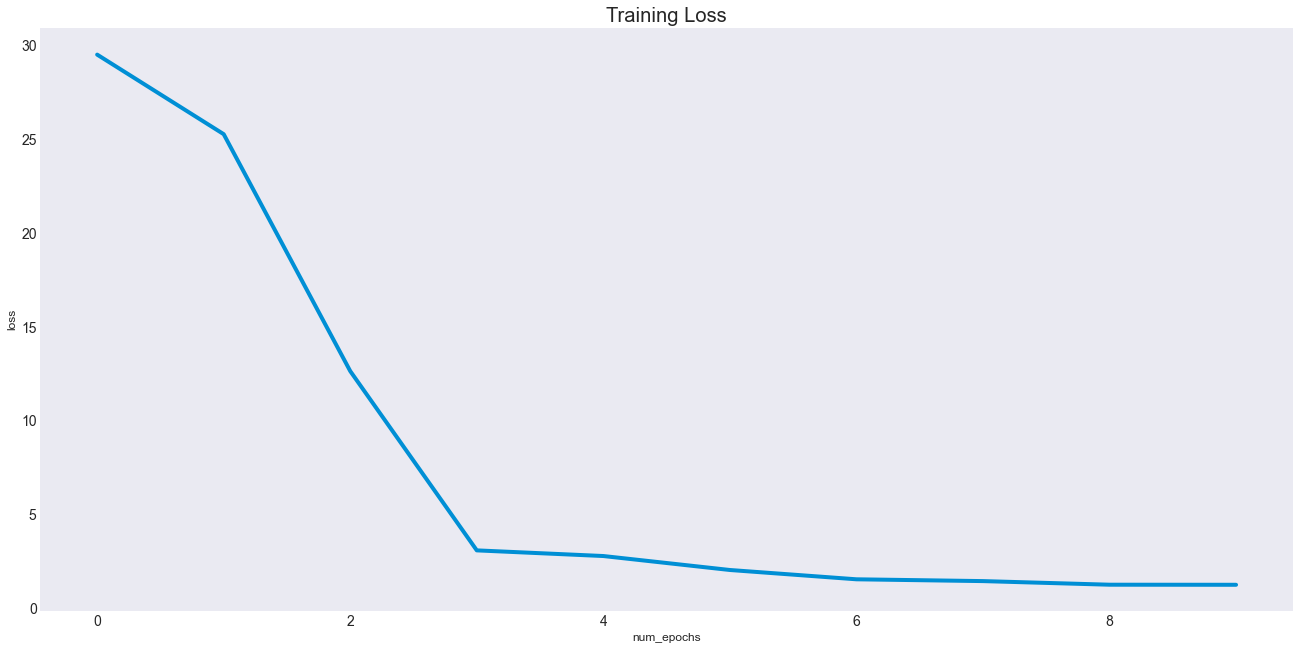

In [38]:
finalLoss = np.zeros((Epoch))
for i in range(Epoch):
    for j in range(n_split):
        finalLoss[i] += totalLoss[j][i]

finalLoss = finalLoss/n_split
print(finalLoss)
fig = plt.figure(figsize=(20, 10))
plt.style.use('seaborn-dark')
plt.title("Training Loss")
plt.plot(finalLoss, label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.savefig(fname='Loss.svg',format='svg')
print(f'Model with minimum validation loss: {np.argmin(valLoss)}, min validation loss: {np.min(valLoss)}')


Last, we reload the model with the least validation loss, and display some images.

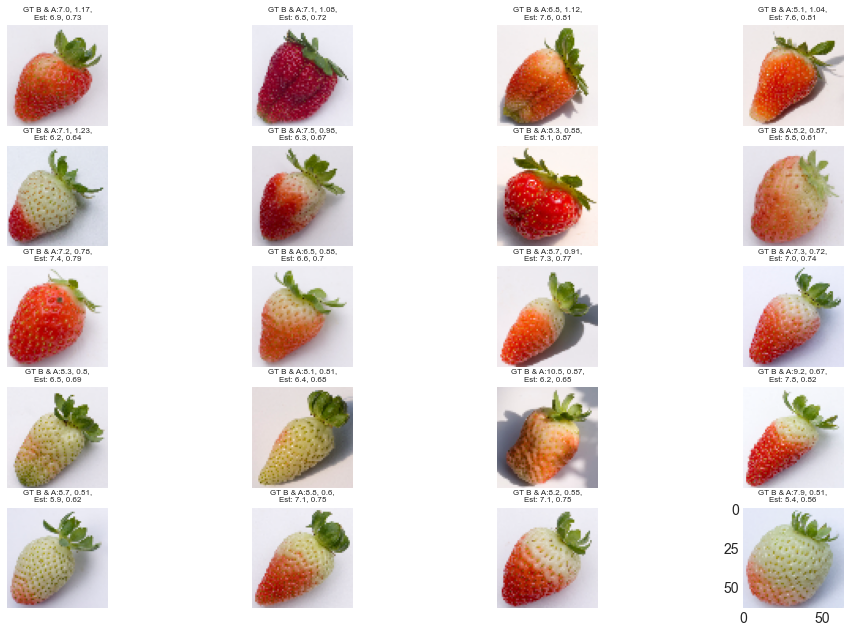

In [37]:
bestModel = Net()
bestModel.load_state_dict(torch.load(f'./ModelFold{np.argmin(valLoss)}.pth'))
Dataloader = torch.utils.data.DataLoader(dataset, batch_size=Batch_size)
# get some random images
count = 0
fig, axis = plt.subplots(4, 5, figsize=(15, 10))
for i in range(len(Data0)):
    if (i+1) % 25 == 0:  # we have 502 images in the dataset, therefore, 20 images will be displayed
        imgPath = Data0.loc[i, 'image']
        if not os.path.exists(imgPath):
            ripe = imgPath.split('_')[2].split('.')[0]
            for subst in ('ripe', 'unripe', 'partripe'):
                if os.path.exists(re.sub(ripe, subst, imgPath)):
                    imgPath = re.sub(ripe, subst, imgPath)

        img = cv2.imread(imgPath)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        brix = Data0.loc[i, 'brix']
        acidity = Data0.loc[i, 'acid']
        img = cv2.resize(img, (64, 64))
        imgTen = transform(img)
        imgTen = torch.unsqueeze(imgTen, 0)
        output = bestModel(imgTen)
        outputBrix = output[0][0].item()
        outputAcid = output[0][1].item()
        # GT: Ground Truth, B: Brix, A: Acid, Est:Estimated
        title = f"GT B & A:{round(brix,4)}, {round(acidity,4)},\nEst: {round(outputBrix,1)}, {round(outputAcid,2)}"
        plt.axis('off')
        plt.subplot(5,4,int((i+1)/25))
        plt.imshow(img)
        plt.title(title,fontsize=8)
        plt.savefig(fname="examples.svg",format="svg")

